**Etude de faisaibilité IMAGE**
-----------------
Ce notebook a objectif d'étudier la faisabilité de classifier la photo associée à chaque produit selon sa catégorie.


On procéde en 3 étapes :
- **Analyse et prétraitement nécessaires des données**
- **Vectorisation numérique des données par plusieurs méthodes** : SIFT avec VBOW, VGG16, ResNet50, InceptionV3, EfficientNetB0
- **Segmentation non supervisée de ces vecteurs**
- **Mesure de la similarité entre les segments et les catégories prédéfinies**


Nous pourrons comparer ces résultats à ceux de la partie vision avant de décider quelle méthode utiliser pour la partie de classification supervisée.

# Imports

In [142]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
from gc import collect

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

from collections import Counter
import cv2
from skimage import io

from sklearn.cluster import MiniBatchKMeans, KMeans
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

In [143]:
# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

# **Chargement des données nettoyées**

In [144]:
image_df = pd.read_pickle('flipkart_cleaned.pkl')
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.4+ KB
None


Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

# **Analyse et prétraitement des données**

Lors de l'analyse pré-exploratoire, on a gardé la colonne `image` qui contient les noms de fichiers avec extension.<br>
Regardons l'analyse sur la taille des images présentes dans le dataset.

In [145]:
# Définition du chemin d'accès au répertoire contenant les images
path = "./Images/"

Je définis une fonction pour extraire les caractéristiques des images dont la largeur, la hauteur, le nombre de canaux et la taille en octets:

In [146]:
def extract_img_features(images, path):
    # Crée des listes pour stocker les caractéristiques des images
    img_height = []
    img_width = []
    img_channels = []
    img_size = []

    # Itère sur la séquence contenant les images pour récupérer les caractéristiques de chaque image
    for img in images:
        image = cv2.imread(path + img, cv2.IMREAD_COLOR)
        img_height.append(image.shape[0])
        img_width.append(image.shape[1])
        img_channels.append(image.shape[2])
        img_size.append(image.size)
        
    # Retourne un DataFrame contenant les caractéristiques des images
    return pd.DataFrame({'height': img_height, 'width': img_width, 'channels': img_channels, 'size': img_size})

Je modifie le dataframe pour ajouter les caractéristiques extraites:

In [147]:
image_df = pd.concat([image_df, extract_img_features(image_df['image'], path)], axis=1)
print(image_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   image     1050 non-null   object  
 1   class     1050 non-null   category
 2   height    1050 non-null   int64   
 3   width     1050 non-null   int64   
 4   channels  1050 non-null   int64   
 5   size      1050 non-null   int64   
dtypes: category(1), int64(4), object(1)
memory usage: 42.2+ KB
None


In [151]:
# Récupère les labels uniques dans une liste
list_labels = list(image_df['class'].unique())
print('Liste des labels :')
print(list_labels)

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


Afin de comprendre les données extraites, je regarde :
- Les statistiques descriptives des caractéristiques extraites
- Un nuage de points pour visualiser la distribution des caractéristiques LxH de chaque image

In [148]:
# Aperçu des statistiques descriptives des features extraites
print(image_df.select_dtypes(include='int').describe())

             height        width  channels          size
count   1050.000000  1050.000000    1050.0  1.050000e+03
mean    1220.038095  1196.570476       3.0  5.748901e+06
std      744.841368   864.076765       0.0  1.175770e+07
min      160.000000   145.000000       3.0  1.740000e+05
25%      844.000000   747.250000       3.0  2.017125e+06
50%     1100.000000  1100.000000       3.0  3.047550e+06
75%     1360.000000  1214.250000       3.0  4.661820e+06
max    11042.000000  8484.000000       3.0  2.810410e+08


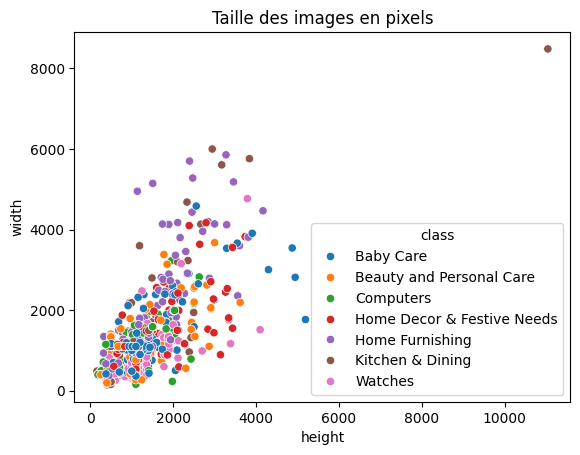

In [149]:
# Crée une figure avec 2 plots en 1 ligne et 2 colonnes
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot de la taille des images
image_df.pipe(sns.scatterplot, x="height", y="width", hue='class', ax=ax[0])
ax[0].title("Répartition des images selon leur dimension Lxh")
ax[0].set_xlabel("Hauteur en pixels")
ax[0].set_ylabel("Largeur en pixels")

# Strip plot de la taille des images
sns.stripplot(x='size', hue='class', data=image_df, ax=ax[1])
ax[1].title("Répartition des images selon leur dimension Lxh")
ax[1].set_xlabel("Hauteur en pixels")
ax[1].set_ylabel("Largeur en pixels")

# Affiche la figure
plt.show()

Voice ce que l'on peut observer d'informatif:
- Les images ont une définition assez grande. La moyenne de la largeur et de la hauteur est à environ 1200 pixels.<br>
- La taille moyenne des images est de 1.5 Mo.<br>
- Les images sont en couleur (3 canaux).<br>
- Présence d'image avec des valeurs extrêmes (largeur et hauteur > 5000 pixels).<br>

# **EVALUATION DE LA SEGMENTATION NON SUPERVISEE**

Pour évualuer la faisabilité du projet, **je vais utiliser différentes méthodes d'embedding d'images pour les vectoriser et ensuite les segmenter en utilisant des algorithmes de clustering non supervisée.**


L'objectif est de voir si les segments obtenus sont cohérents avec les catégories prédéfinies.<br>
J'utiliserai **l'indice de Rand ajusté pour mesurer la similarité entre les clusters obtenus et les catégories prédéfinies.**<br>
Un score proche de 1 indique une similarité parfaite entre les clusters et les catégories alors qu'un score proche de 0 indique une similarité aléatoire.<br>


En plus du score, je vais effectueur une comparaison visuelle des clusters obtenus avec les catégories prédéfinies pour voir **si les clusters obtenus sont bien séparés et cohérents.**


Si une méthode d'embedding et de clustering donne des résultats satisfaisants, **je pourrai l'utiliser pour la classification supervisée des produits.**

In [187]:
# Définition d'une fonction pour calculer l'ARI après segmentation avec KMeans et réduction de dimension avec Tsne
def compute_ari(X, y=image_df['class'], tsne=True):
    # Détermination des clusters à partir des données avant Tsne
    cls = KMeans(n_clusters=y.nunique(), n_init=100, random_state=42)
    cls.fit(X)

    # Calcul de l'ARI
    ARI = np.round(adjusted_rand_score(y, cls.labels_), 4)

    # Réduction de dimension avec Tsne si tsne=True
    if tsne:
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            max_iter=2000,
            init="random",
            learning_rate=200,
            random_state=42,
        )
        X_tsne = tsne.fit_transform(X)
        # Retourne l'ARI, les données réduites et les clusters
        return ARI, X_tsne, cls.labels_
    else:
        # Retourne l'ARI et les clusters
        return ARI, cls.labels_

In [186]:
# Définit une fonction pour comparer les embeddings TSNE avec les catégories réelles et les clusters
def compare_cluster_and_cat(X_tsne, clusters, y=image_df['class']):
    fig = plt.figure(figsize=(13, 5), tight_layout=True)

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.cat.codes, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=y.unique(),
        loc="best",
        title="Categorie",
    )
    plt.title("Représentation des commentaires par catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap="Set1")
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(clusters),
        loc="best",
        title="Clusters",
    )
    plt.title("Représentation des commentaires par clusters")

    plt.show()

Je crée une liste qui contiendra le stockage des scores sous forme de tuple avec `('nom', dimensions, score)`.

In [203]:
ari_scores = list()

## **SIFT avec Visual Bag of Words**

La première méthode utilisée est SIFT avec la construction d'un Visual Bag of Words (VBOW).<br>
La méthode SIFT permet d'extraire des points d'intérêt et des descripteurs de ces points.<br>
Les descripteurs représentent les caractéristiques de l'image et sont de dimensions 128.<br>
Le VBOW se construit en appliquant un algorithme de clustering pour réduire la dimensionnalité sur le nombre de descripteurs créés.<br>
Les labels des clusters sont ensuite comptabilisés sous forme d'histogramme pour chaque image.<br>
Les histogrammes sont normalisées pour que chaque vecteur ait une norme de 1.<br>


A partir de cette matrice d'histogramme représentant un vecteur pour chaque image, nous pourrons calculer l'ARI pour voir si les clusters obtenus sont cohérents avec les catégories prédéfinies.

## Définition des fonctions utilisés pour construire le VBOW et les métriques

In [153]:
def custom_resize(height, width, max_size, path, image, greyscale=True):
    # Choisis la valeur maximale entre la hauteur et la largeur
    max_value = max(height, width)
    # Calcule le ratio pour redimensionner l'image sans déformer l'aspect ratio
    scale_ratio = max_size / max_value
    height = int(height * scale_ratio)
    width = int(width * scale_ratio)
    # Lit et redimensionne l'image aux nouvelles dimensions avec une interpolation bilinéaire par défaut
    image = cv2.imread(path + image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (height, width), interpolation=cv2.INTER_AREA) # Adapté pour redimenssionner avec de l'anitaliasing
    # Convertir en niveaux de gris
    if greyscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Efface les variables intermédiaires
    del(max_value, scale_ratio, height, width)
    collect()
    # Retourne l'image
    return image

In [154]:
def extract_descriptors(df, path, max_size:int=None, resize:tuple=None, equalize='clahe'):
    sift_descriptors = []
    # Itere sur le fataframe
    for row in tqdm(df.itertuples()):
        # Si max_size est défini, redimensionne l'image si elle dépasse la valeur de max_size soit en hauteur ou en largeur
        if max_size is not None:
            if row.height > max_size or row.width > max_size:
                image = custom_resize(row.height, row.width, max_size, path, row.image)
        # Si resize est défini, redimensionne l'image aux dimensions spécifiées avec une interpolation bilinéaire
        elif resize is not None:
            image = cv2.imread(path + row.image, cv2.IMREAD_COLOR)
            image = cv2.resize(image, resize, interpolation=cv2.INTER_AERA)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            image = cv2.imread(path + row.image, cv2.IMREAD_GRAYSCALE)
        match equalize:
            case 'clahe':
                # Applique l'histogramme adaptatif
                clahe = cv2.createCLAHE()
                image = clahe.apply(image)
            case 'hist':
                # Applique l'égalisation d'histogramme
                image = cv2.equalizeHist(image)
            case None:
                pass
            case _:
                raise ValueError("equalize doit être soit 'clahe' ou 'hist' ou None")
        # Initialise l'objet SIFT
        sift = cv2.SIFT_create()
        # Détecte et calcule les descripteurs SIFT avec une normalisation L2 intégré au processus
        _, descriptors = sift.detectAndCompute(image, None)
        # Renvoie le descripteur
        sift_descriptors.append(descriptors)
    # Efface les variables intermédiaires
    del(image, sift, descriptors)
    collect()
    # Retourne le descripteur
    return sift_descriptors
    


In [155]:
# Fonction pour déterminer un range de cluster à tester pour déterminer le nombre optimal de Visual Words
def cluster_range(X, list_labels, n=10):
    if n<2:
        raise ValueError("Le nombre de clusters doit être supérieur à 2")  
    
    # Détermination du nombre de clusters avec la racine carrée du nombre de descriptors
    n_clusters_sqrt = int(np.sqrt(len(X)))
    print("Nombre de clusters - méthode racine carrée : ", n_clusters_sqrt)

    # Détermination du nombre de clusters par multiplier par 10 le nombre de labels existants
    n_clusters_ten = len(list_labels) * 10
    print("Nombre de clusters - méthode nbre_labels * 10 : ", n_clusters_ten)

    if n==2:
        rng_clusters = [n_clusters_ten, n_clusters_sqrt]
    else:
        # Création d'une liste de n clusters à tester
        rng_clusters = np.linspace(n_clusters_ten, n_clusters_sqrt, n).astype(int)
    print("Longueur de la liste de clusters à tester: ", len(rng_clusters))

    return rng_clusters

In [156]:
# Fonction pour retourner les centroides selon un nombre de clusters choisis
def compute_labels(X, n_clusters):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans.labels_

In [157]:
def return_histogram(descriptors, kmeans, n_cluster):
    labels = kmeans.predict(descriptors)
    hist = Counter(labels)
    hist = dict(sorted(hist.items()))
    # Convertit le dictionnaire en array de longeur n_cluster
    hist = np.array([hist.get(i) if i in hist.keys() else 0 for i in range(n_cluster)])
    # Supprime les variables intermédaires
    del(labels)
    collect()
    # Retourne l'histogramme
    return hist

In [158]:
def return_vbow_and_labels(X, n_cluster, sift_descriptors, normalize=True):
    # Crée le modèle KMeans
    kmeans = MiniBatchKMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    # Initialise la liste pour stocker les histogrammes
    vbow = []
    for descriptors in tqdm(sift_descriptors):
        hist = return_histogram(descriptors, kmeans, n_cluster)
        vbow.append(hist)
    # Convertit la liste en array
    vbow = np.array(vbow)
    # Normalise les histogrammes si normalize=True
    if normalize:
        return vbow / np.sum(vbow, axis=1, keepdims=True), labels
    else:
        return vbow, labels

## Test des combinaisons de paramètres

In [200]:
sift_descriptors = extract_descriptors(
    image_df,
    path,
    max_size=244,
    equalize='clahe'
)

1050it [04:49,  3.63it/s]


In [202]:
# Chaque élément de la liste contient une array de (n, 128) où n est le nombre de points d'intérêt détectés
X = np.concatenate(sift_descriptors, axis=0)
print("Points d'intérêts / descripteurs image : ", X.shape)

# Détermine le range de clusters à tester
rng_clusters = cluster_range(X, list_labels, n=5)

Points d'intérêts / descripteurs image :  (431502, 128)
Nombre de clusters - méthode racine carrée :  656
Nombre de clusters - méthode nbre_labels * 10 :  70
Longueur de la liste de clusters à tester:  5


In [204]:
for n_clust in rng_clusters:
    vbow, labels = return_vbow_and_labels(X, n_clust, sift_descriptors, normalize=True)
    print('Dimensions du Visual Bag of Words : ', vbow.shape)
    pca = PCA(n_components=0.99)
    pca_vector = pca.fit_transform(vbow)
    print('Dimensions après réduction de dimension : ', pca_vector.shape)
    kmeans = KMeans(n_clusters=len(list_labels), random_state=42)
    kmeans.fit(pca_vector)
    ari = adjusted_rand_score(kmeans.labels_, image_df['class'])
    ari_scores.append(("SIFT", pca_vector.shape[1], ari))
    _, _,max_ari = max(ari_scores, key=lambda x: x[2])
    if max(ari, max_ari)==ari:
        best_pca_vector = pca_vector
        best_labels = kmeans.labels_
del (X, sift_descriptors, vbow, pca_vector, pca, kmeans)

100%|██████████| 1050/1050 [03:04<00:00,  5.69it/s]


Dimensions du Visual Bag of Words :  (1050, 70)
Dimensions après réduction de dimension :  (1050, 64)


100%|██████████| 1050/1050 [03:16<00:00,  5.36it/s]


Dimensions du Visual Bag of Words :  (1050, 216)
Dimensions après réduction de dimension :  (1050, 195)


100%|██████████| 1050/1050 [03:07<00:00,  5.60it/s]


Dimensions du Visual Bag of Words :  (1050, 363)
Dimensions après réduction de dimension :  (1050, 318)


100%|██████████| 1050/1050 [03:11<00:00,  5.48it/s]


Dimensions du Visual Bag of Words :  (1050, 509)
Dimensions après réduction de dimension :  (1050, 432)


100%|██████████| 1050/1050 [02:58<00:00,  5.88it/s]


Dimensions du Visual Bag of Words :  (1050, 656)
Dimensions après réduction de dimension :  (1050, 529)


In [205]:
print("Affichage du meilleur score au moins bon:")
print(sorted(ari_scores, key=lambda x: x[2], reverse=True))

Affichage du meilleur score au moins bon:
[('SIFT', 64, 0.056941556988069505), ('SIFT', 195, 0.05140563480343261), ('SIFT', 432, 0.022031694302130655), ('SIFT', 529, 0.01730560765721346), ('SIFT', 318, 0.016902475146200555)]


ARI :  0.056941556988069505 Dimension du vecteur:  64


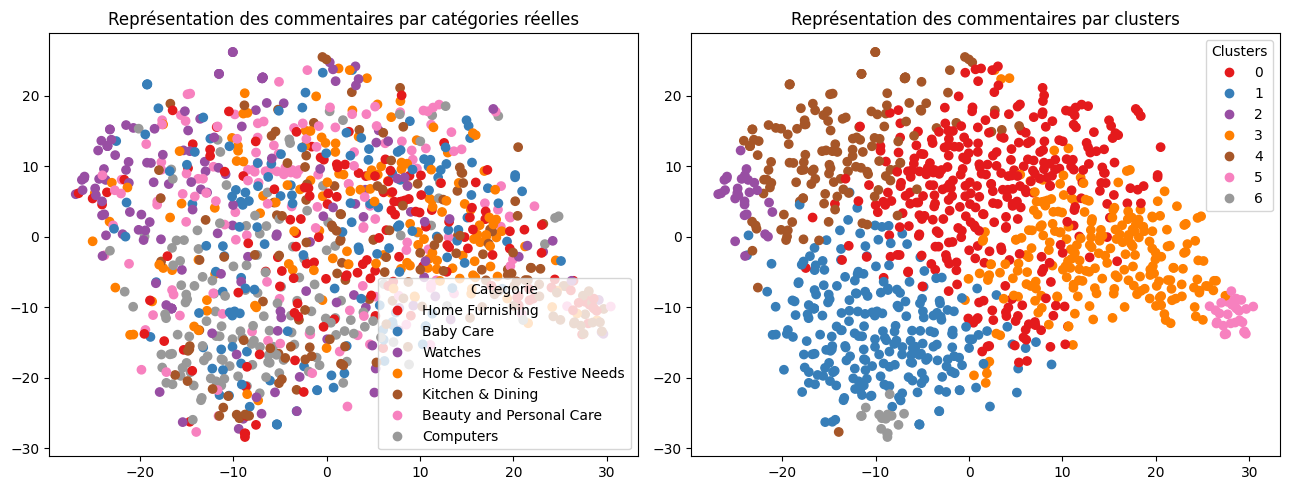

In [208]:
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(best_pca_vector)
print("ARI : ", max_ari, "Dimension du vecteur: ", best_pca_vector.shape[1])
compare_cluster_and_cat(X_tsne, best_labels, image_df['class'])

# CNN

Test des différents modèles de CNN pour l'étude de faisabilité

In [11]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0

In [12]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

In [13]:
def extract_embeddings(model, images, path, preprocess_input):
    input_shape = model.input.shape
    input_size = (input_shape[1], input_shape[2])
    print(f"Input size: {input_size}")
    last_layer = model.layers[-2]
    model = Model(inputs=model.inputs, outputs=last_layer.output)
    images_embeddings = []
    for img in images:
        clear_output()
        image = cv2.imread(path + img)
        image = cv2.resize(image, input_size)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        image_embedding = model.predict(image)
        images_embeddings.append(image_embedding)
    images_embeddings = np.asarray(images_embeddings)
    return images_embeddings

In [14]:
def ARI_cnn(images, embeddings, n_clusters=7):
    # Affiche la taile des embeddings
    print('Raw shape: ', embeddings.shape)
    embeddings_flat = embeddings.reshape(embeddings.shape[0], -1)
    print('Flat shape: ', embeddings_flat.shape)

    # Réduction de la dimensionnalité des embeddings
    pca = PCA(n_components=0.95)

    # Fit et transforme les embeddings
    embeddings_pca = pca.fit_transform(embeddings_flat)
    # Affiche la taille des embeddings après PCA
    print('PCA shape: ', embeddings_pca.shape)

    # Crée le modèle KMeans
    n_clusters = n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings_pca)

    ari = adjusted_rand_score(images, clusters)
    print(f"Adjusted Rand Index: {ari}")
    return ari

In [15]:
embeddings = extract_embeddings(VGG16(), image_df['image'], path, vgg16_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

KeyboardInterrupt: 

In [67]:
embeddings = extract_embeddings(ResNet50(), image_df['image'], path, resnet50_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Raw shape:  (1050, 1, 2048)
Flat shape:  (1050, 2048)
PCA shape:  (1050, 412)
Adjusted Rand Index: 0.41595772766026823


0.41595772766026823

In [68]:
embeddings = extract_embeddings(InceptionV3(), image_df['image'], path, inception_v3_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Raw shape:  (1050, 1, 2048)
Flat shape:  (1050, 2048)
PCA shape:  (1050, 411)
Adjusted Rand Index: 0.4929040017460021


0.4929040017460021

In [69]:
embeddings = extract_embeddings(EfficientNetB0(), image_df['image'], path, efficientnet_preprocess_input)
ARI_cnn(image_df['class'], embeddings, n_clusters=7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Raw shape:  (1050, 1, 1280)
Flat shape:  (1050, 1280)
PCA shape:  (1050, 416)
Adjusted Rand Index: 0.5004776367526101


0.5004776367526101

## Visualisation des résultats

On va retenir le modèle EfficientNetB0 pour regarder la visualisation des résultats:

In [70]:
# Paramètres pour T-SNE
tsne = TSNE(n_components=2, perplexity=30, 
                     max_iter=2000, init='random', random_state=42)

# Paramètres pour PCA
pca = PCA(n_components=0.95)
pca_vector = pca.fit_transform(embeddings.reshape(embeddings.shape[0], -1))
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(pca_vector)
X_tsne = tsne.fit_transform(pca_vector)
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = image_df['class']
df_tsne["labels"] = kmeans.labels_
df_tsne['class'] = df_tsne['class'].astype('category')

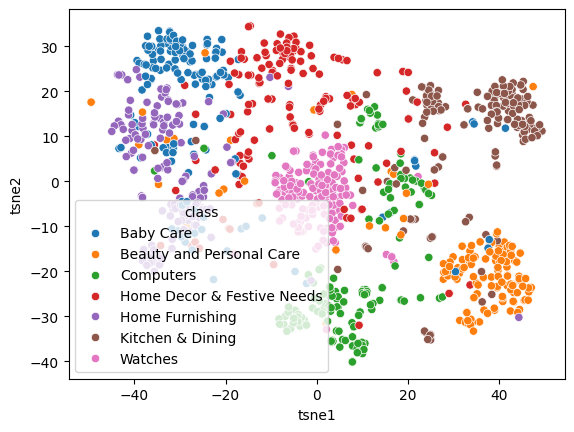

In [71]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='class')
plt.show()

<Axes: xlabel='tsne1', ylabel='tsne2'>

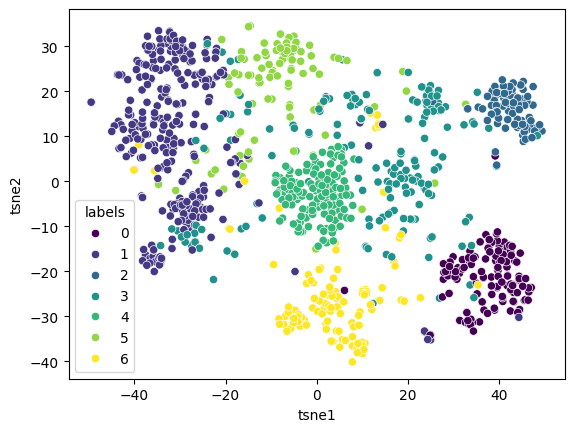

In [72]:
sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='labels', palette='viridis')